<a href="https://colab.research.google.com/github/NoelleI/Udacity-Deployment/blob/master/Heartbeat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:


'''Step 1 Detect Skin 
this code was adapted from https://www.pyimagesearch.com/2014/08/18/skin-detection-step-step-example-using-python-opencv/
and
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/'''

# import the necessary packages
import imutils
import numpy as np
import argparse
import cv2
from matplotlib import pyplot
from google.colab.patches import cv2_imshow


# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin'

#take out the skin detection:
lower = np.array([0, 0, 0], dtype = "uint8")
upper = np.array([255, 255, 255], dtype = "uint8")

#include the skin detection:
#lower = np.array([0, 48, 80], dtype = "uint8")
#upper = np.array([20, 255, 255], dtype = "uint8")



camera = cv2.VideoCapture("IMG_4329.MOV")  
n_frames = int(camera.get(cv2.CAP_PROP_FRAME_COUNT))
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
print(n_frames)




ra = []
ga = []
ba = []
box = []

# keep looping over the frames in the video
for i in range(n_frames):
    
    print(i)
	# grab the current frame
    (grabbed, frame) = camera.read()
	# if we are viewing a video and we did not grab a
	# frame, then we have reached the end of the video
	# resize the frame, convert it to the HSV color space,
	# and determine the HSV pixel intensities that fall into
	# the speicifed upper and lower boundaries
    if grabbed:
        frame = imutils.resize(frame, width = 400)
        frame = imutils.rotate(frame, 180)
        converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        skinMask = cv2.inRange(converted, lower, upper)
	# apply a series of erosions and dilations to the mask
	# using an elliptical kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
        skinMask = cv2.erode(skinMask, kernel, iterations = 2)
        skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
	# blur the mask to help remove noise, then apply the
	# mask
        skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
        skin = cv2.bitwise_and(frame, frame, mask = skinMask)

        bboxes = classifier.detectMultiScale(skin, 1.05, 8)
        print('len bboxes:', len(bboxes))
        if box == []:  
          if len(bboxes) ==0:
            print("face not detected in first frame")
            cv2_imshow(np.vstack([frame, skin]))  ##change to an assert later
          else:
            box = bboxes[0]
#choose the box most like the last frame, if more than one box. If zero boxes, use box from last frame
        else:
          if len(bboxes) ==0:
            box = box   
            print("old box used") 
          else:
           test2 = np.zeros(len(bboxes))
           for i, boxnew in enumerate(bboxes):
            [xn, yn, widthn, heightn] = boxnew 
            x2n = xn + widthn
            y2n = yn + heightn
           	# draw a rectangle mask and compare to box from previous frame
            tempn = np.zeros([frame.shape[0], frame.shape[1]])
            tempn = tempn.astype(np.uint8)
            cv2.rectangle(tempn, (xn, yn), (x2n, y2n), (255,255,255), -1)
            test = cv2.bitwise_and(temp, temp, mask = tempn)
            test2[i] = np.mean(test)
           boxt = bboxes[np.argmax(test2)]
           if boxt[3] <= width*0.9 or boxt[3] >= width*1.1:
             box = box
             print("old box used")
             
           else:
             box = boxt
             print("nearest box used")
            
	# extract
        [x, y, width, height] = box 
        x2 = x + width
        y2 = y + height
        x2 = int(x2 - 0.2*width)
        x = int(x + 0.2*width)
        #y2 = int(y2 - 0.8*height)
           	# draw a rectangle over the pixels
        temp = np.zeros([frame.shape[0], frame.shape[1]])
        cv2.rectangle(temp, (x, y), (x2, y2), (255,255,255), -1)
        temp = temp/255
        temp = temp.astype(np.uint8)
        skin = cv2.bitwise_and(skin, skin, mask = temp)
        #cv2_imshow(np.vstack([frame, skin]))



        #find the average red, green and blue in the skin
        N = 0
        r=0
        g=0
        b=0
        skinr = skin[:,:,0].reshape(-1)
        sking = skin[:,:,1].reshape(-1)
        skinb = skin[:,:,2].reshape(-1)

        #print(skinMask.shape)
        for i, pixel in enumerate(skinMask.reshape(-1)):
          if  not pixel==0:
            r += skinr[i]
            g += sking[i]
            b += skinb[i]
            N+=1
        ra += [r/N] 
        ga += [g/N]
        ba += [b/N]




	# show the skin in the image along with the mask
      
        #cv2_imshow(np.vstack([frame, skin]))
# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()

1846
0
len bboxes: 1
1
len bboxes: 1
nearest box used


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Streaming output truncated to the last 5000 lines.
nearest box used
180
len bboxes: 1
nearest box used
181
len bboxes: 1
nearest box used
182
len bboxes: 1
nearest box used
183
len bboxes: 1
nearest box used
184
len bboxes: 1
nearest box used
185
len bboxes: 1
nearest box used
186
len bboxes: 1
nearest box used
187
len bboxes: 1
nearest box used
188
len bboxes: 1
nearest box used
189
len bboxes: 1
nearest box used
190
len bboxes: 1
nearest box used
191
len bboxes: 1
nearest box used
192
len bboxes: 1
nearest box used
193
len bboxes: 1
nearest box used
194
len bboxes: 1
nearest box used
195
len bboxes: 1
nearest box used
196
len bboxes: 1
nearest box used
197
len bboxes: 1
nearest box used
198
len bboxes: 1
nearest box used
199
len bboxes: 1
nearest box used
200
len bboxes: 1
nearest box used
201
len bboxes: 1
nearest box used
202
len bboxes: 1
nearest box used
203
len bboxes: 1
nearest box used
204
len bboxes: 1
nearest box used
205
len bboxes: 1
nearest box used
206
len bboxes: 1
near

In [85]:
ra = np.array(ra)

In [86]:
np.argmin(ra)

1467

In [87]:
ra[np.argmin(ra)]

12.350333333333333

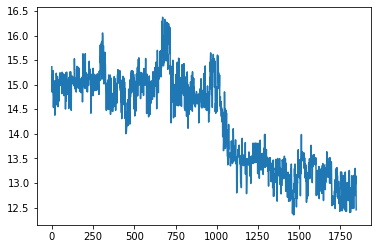

In [88]:
import matplotlib.pyplot as plt

plt.plot(ra)

In [89]:
ga = np.array(ga)
ba = np.array(ba)

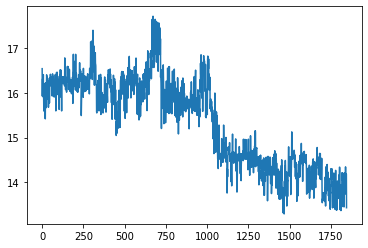

In [90]:
plt.plot(ga)

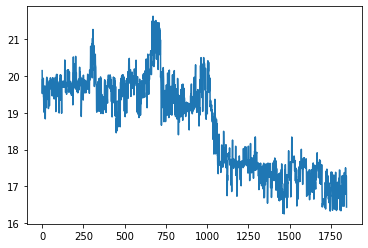

In [91]:
plt.plot(ba)

In [92]:
from sklearn.decomposition import FastICA
from scipy import signal
transformer = FastICA(n_components=3)

In [93]:
#normalize over 30s windows as in Poe et al.
n30 = int((n_frames - 900)/30) #number of 30 second sliding windows
ran = np.zeros(900)
gan = np.zeros(900)
ban = np.zeros(900)
for i in range(n30):
  rav = np.mean(ra[i*30:i*30+900])
  gav = np.mean(ga[i*30:i*30+900])
  bav = np.mean(ba[i*30:i*30+900])
  rstd = np.std(ra[i*30:i*30+900])
  gstd = np.std(ga[i*30:i*30+900])
  bstd = np.std(ba[i*30:i*30+900])
  for j in range(900):
    ran[j] = (ra[i*30 + j] - rav)/rstd
    gan[j] = (ga[i*30 + j] - gav)/gstd
    ban[j] = (ba[i*30 + j] - bav)/bstd
  X = np.array(list(zip(ran,gan,ban)))
  X_transformed = transformer.fit_transform(X)
  X_indep = X_transformed.transpose()
  #plt.plot(X_indep[0])
  #plt.show()
  #plt.plot(X_indep[1])
  #plt.show()
  #plt.plot(X_indep[2])
  #plt.show()

  ratio = np.zeros(3)
  hr = np.zeros(3)

  x1 = X_indep[1]
  x1_corr = signal.correlate(x1, x1, mode='same')
  #plt.plot(x1_corr)
  #plt.show()
  ff = np.fft.hfft(x1_corr[:int(len(x1_corr)/2)])
  fs_n = 30/len(x1_corr/2)
  upper = int(4/fs_n)
  lower = int(0.75/fs_n)
  #plt.plot((abs(ff[lower:upper])))
  #plt.show()
  hr1 = int((np.argmax(abs(ff[lower:upper])) + lower))
  max1 = np.max(abs(ff[lower:upper]))
  hr2array = np.concatenate([ff[lower:hr1 - 2], ff[hr1 + 2:upper]], axis = 0)
  max2 = np.max(abs(hr2array))
  ratio[1] = max2/max1
  #print(ratio[1])
  if max2 <= 0.6*max1:
    hr[1] = hr1*60*fs_n
    #print("estimated heartrate x1", hr[1])
  #else:
    #print("waiting x1")


  x2 = X_indep[2]
  x2_corr = signal.correlate(x2, x2, mode='same')
  #plt.plot(x2_corr)
  #plt.show()
  ff = np.fft.hfft(x2_corr[:int(len(x2_corr)/2)])
  fs_n = 30/len(x2_corr/2)
  upper = int(4/fs_n)
  lower = int(0.75/fs_n)
  #plt.plot((abs(ff[lower:upper])))
  #plt.show()
  hr1 = int((np.argmax(abs(ff[lower:upper])) + lower))
  max1 = np.max(abs(ff[lower:upper]))
  hr2array = np.concatenate([ff[lower:hr1 - 2], ff[hr1 + 2:upper]], axis = 0)
  max2 = np.max(abs(hr2array))
  ratio[2] = max2/max1
  #print(ratio[2])
  if max2 <= 0.6*max1:
    hr[2] = hr1*60*fs_n
    #print("estimated heartrate x2", hr[2])
  #else:
    #print("waiting x2")


  x0 = X_indep[0]
  x0_corr = signal.correlate(x0, x0, mode='same')
  #plt.plot(x0_corr)
  #plt.show()
  ff = np.fft.hfft(x0_corr[:int(len(x0_corr)/2)])
  fs_n = 30/len(x0_corr/2)
  upper = int(4/fs_n)
  lower = int(0.75/fs_n)
  #plt.plot((abs(ff[lower:upper])))
  #plt.show()
  hr1 = int((np.argmax(abs(ff[lower:upper])) + lower))
  max1 = np.max(abs(ff[lower:upper]))
  hr2array = np.concatenate([ff[lower:hr1 - 2], ff[hr1 + 2:upper]], axis = 0)
  max2 = np.max(abs(hr2array))
  ratio[0] = max2/max1
  #print(ratio[0])
  if max2 <= 0.6*max1:
    hr[0] = hr1*60*fs_n
    #print("estimated heartrate x0", hr[0])
  #else:
    #print("waiting x0")

  print("Heart Rate is ", hr[np.argmin(ratio)])
  #print("Best Component is ", np.argmin(ratio) )

Heart Rate is  78.0
Heart Rate is  76.0
Heart Rate is  78.0
Heart Rate is  78.0


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Heart Rate is  78.0
Heart Rate is  78.0
Heart Rate is  78.0
Heart Rate is  78.0
Heart Rate is  0.0
Heart Rate is  44.0
Heart Rate is  46.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  44.0
Heart Rate is  0.0
Heart Rate is  46.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  78.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  0.0
Heart Rate is  78.0
Heart Rate is  78.0
Heart Rate is  46.0
Heart Rate is  46.0


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


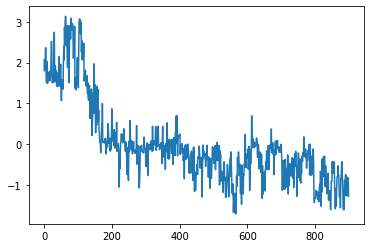

In [94]:
plt.plot(ran)

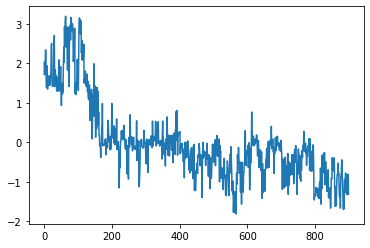

In [95]:
plt.plot(gan)

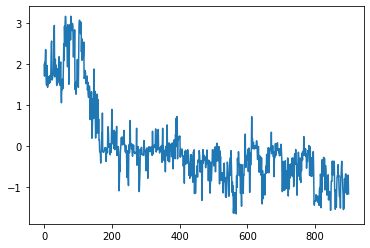

In [96]:

plt.plot(ban)